# Exploring the dataset

In [258]:
data = catalog.load("ena-diario-parana")

2021-12-14 14:59:35,514 - kedro.io.data_catalog - INFO - Loading data from `ena-diario-parana` (CSVDataSet)...


In [259]:
data.head()

,nom_bacia,ena_bruta_bacia_mwmed,ena_bruta_bacia_percentualmlt,ena_armazenavel_bacia_mwmed,ena_armazenavel_bacia_percentualmlt
ena_data,,,,,
2000-01-01,PARANA,12073.358398,58.836899,12073.358398,58.836899
2000-01-02,PARANA,12579.799805,61.305000,12579.799805,61.305000
2000-01-03,PARANA,13393.181641,65.268799,13393.181641,65.268799
2000-01-04,PARANA,14473.228516,70.532204,14473.228516,70.532204
2000-01-05,PARANA,15750.317383,76.755798,15750.317383,76.755798


In [260]:
data.tail()

,nom_bacia,ena_bruta_bacia_mwmed,ena_bruta_bacia_percentualmlt,ena_armazenavel_bacia_mwmed,ena_armazenavel_bacia_percentualmlt
ena_data,,,,,
2021-12-02,PARANA,11912.621094,71.790199,11903.760742,71.736801
2021-12-03,PARANA,11690.402344,70.450996,11637.678711,70.133202
2021-12-04,PARANA,11435.442383,68.914497,11424.749023,68.849998
2021-12-05,PARANA,11159.250000,67.250000,11145.197266,67.165398
2021-12-06,PARANA,10951.396484,65.997398,10947.119141,65.971703


In [261]:
data.describe()

,ena_bruta_bacia_mwmed,ena_bruta_bacia_percentualmlt,ena_armazenavel_bacia_mwmed,ena_armazenavel_bacia_percentualmlt
count,8011.000000,8011.000000,8011.000000,8011.000000
mean,16243.667103,109.707617,14477.458312,98.301099
std,7641.711622,36.133765,5887.913543,25.677907
min,4149.000000,18.320000,4621.824219,30.540001
25%,10528.000000,85.456001,10018.000000,81.405003
50%,14535.548828,104.519997,13526.000000,95.902100
75%,20406.500000,127.230003,17713.869141,112.895000
max,48903.000000,321.726105,40310.000000,235.066895


<AxesSubplot:xlabel='ena_data'>

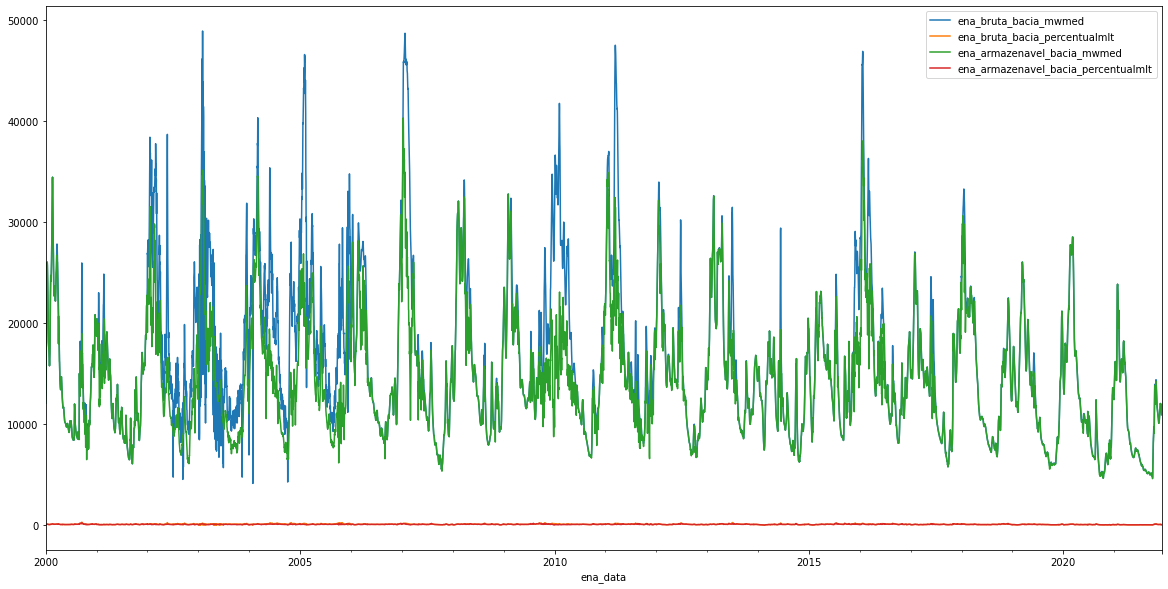

In [262]:
data.plot()

<AxesSubplot:xlabel='ena_data'>

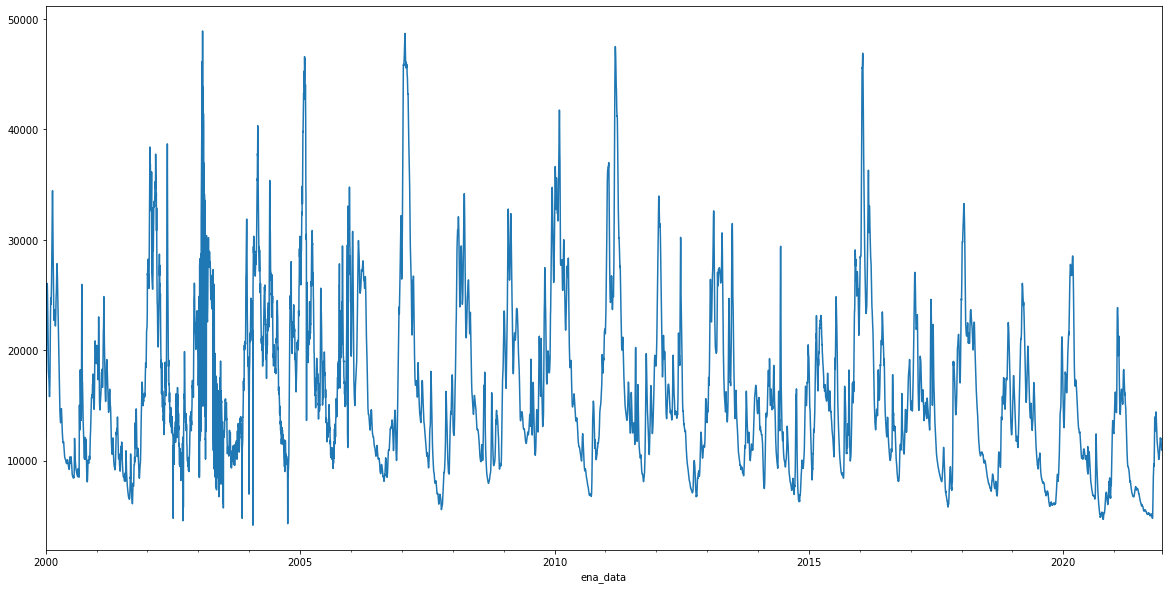

In [263]:
data['ena_bruta_bacia_mwmed'].plot()

<AxesSubplot:xlabel='ena_data'>

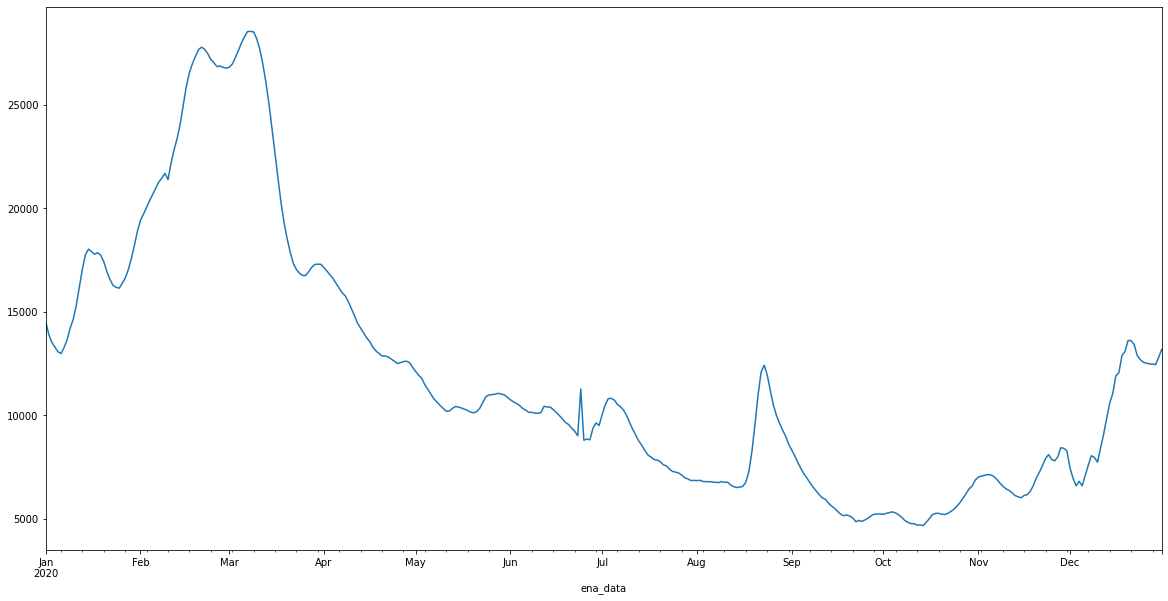

In [266]:
data['ena_bruta_bacia_mwmed'][data.index.year==2020].plot()

In [267]:
import pywt
import pandas as pd
import numpy as np


def generate_windows(df, window_size, shift):
    N = len(data)
    
    df = df.reset_index()
    
    windows = []

    k = 0
    window_id = 1
    while (N-k-window_size) >= 0:
        window = df[['ena_data','ena_bruta_bacia_mwmed']].iloc[(N-k-window_size):(N-k)].reset_index()
        window['window_id'] = window_id
        window['window_index'] = range(0,window_size)
        window.set_index('ena_data',inplace=True)
        
        piv = window.pivot(index='window_id', columns='window_index', values="ena_bruta_bacia_mwmed")
        piv['from_date'] = min(window.index.date)
        piv['to_date'] = max(window.index.date)
        
        windows.append(piv)
        
        k = k + shift
        window_id += 1
        
    return pd.concat(windows)


def split_data(data, split = [.7,.1,.2]):

    N = len(data)

    n_valid = int(split[1]*N) 
    n_test  = int(split[2]*N)
    n_train = N - n_valid - n_test

    train = data[:n_train]
    valid = data[n_train:n_train+n_valid]
    test = data[n_train+n_valid:n_train+n_valid+n_test]
    
    return train, valid, test


def split_xy(data, input_width):
    ts_values = data.drop(['from_date','to_date'], axis=1)
    
    x_col = ts_values.columns[:input_width]
    y_col = ts_values.columns[input_width:]
    
    return ts_values[x_col], ts_values[y_col]


def zscore(data, avg, std):
    
    scaled = data.sub(avg)
    scaled = scaled.divide(std)
    
    return scaled

def extract_features(ts, wavelet, include_ts = True):
    
    level = int(np.log(len(ts)))
    if include_ts is True:
        features = ts
    else:
        features = np.array([])
        
    cA = ts
    for l in range(1,level+1):
        cA, cD = pywt.dwt(cA, wavelet)
        
        features = np.concatenate([features,cD])
        
    features = np.concatenate([features,cA])
    
    return features

In [268]:
def generate_training_data(windows, input_width, target_width, wavelet, include_ts, shift, split):
    
    # Split training data
    print("Spliting data into training, validation and testing datasets...")
    train, valid, test = split_data(windows, split)
    
    # Split X and Y
    print("Spliting model inputs and outputs (X and Y)")
    train_x, train_y = split_xy(train, input_width)
    valid_x, valid_y = split_xy(valid, input_width)
    test_x, test_y = split_xy(test, input_width)
    
    # Scale Data with Training Dataset
    print("Calculate average and standard deviation for training dataset...")
    ts_data = train.values[:,:-2] # Remove last columns with datetime

    train_avg = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).mean()
    train_std = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).std()
    print("Training dataset average: {}".format(round(train_avg,2)))
    print("Training dataset standard deviation: {}".format(round(train_std,2)))

    print("Scaling training, validation and testing datasets using z-score...")
    scaled_train_x = zscore(train_x, train_avg, train_std)
    scaled_train_y = zscore(train_y, train_avg, train_std)
    scaled_valid_x = zscore(valid_x, train_avg, train_std)
    scaled_valid_y = zscore(valid_y, train_avg, train_std)
    scaled_test_x  = zscore(test_x, train_avg, train_std)
    scaled_test_y  = zscore(test_y, train_avg, train_std)
    
    
    # Extract Features
    def get_dwt(x):    
        return extract_features(x, wavelet, include_ts)
    
    if wavelet == None:
        print("Returning values without DWT transformation.")
        return (scaled_train_x, scaled_valid_x, scaled_test_x,
                scaled_train_y, scaled_valid_y, scaled_test_y, train_avg, train_std)
    else:
        print("Returning values with DWT transformation with {} wavelet.".format(wavelet))
        dwt_scaled_train_x = scaled_train_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
        dwt_scaled_valid_x = scaled_valid_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
        dwt_scaled_test_x  = scaled_test_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
    
        return (dwt_scaled_train_x, dwt_scaled_valid_x, dwt_scaled_test_x,
                scaled_train_y, scaled_valid_y, scaled_test_y, train_avg, train_std)

# Common parameters

In [139]:
output_dim = 15 # Number of points in Y samples
layer_1 = 1200 # Number of neurons on first layer
layer_2 = 600 # Number of neurons on second layer
lr = 0.000001 # MLP learning rate
metrics = ['rmse','mae','mse']

<img src="img/lr.png">

# Generating Windows

In [140]:
data         = catalog.load("ena-diario-parana")
input_width  = 128
target_width = 15 
shift        = 1

2021-12-14 13:01:48,563 - kedro.io.data_catalog - INFO - Loading data from `ena-diario-parana` (CSVDataSet)...


In [130]:
window_size = input_width + target_width
windows = generate_windows(data, window_size, shift)

In [131]:
windows.head()

window_index,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,from_date,to_date
window_id,,,,,,,,,,,,,,,,,,,,,
1,6009.165039,6026.303223,6012.338867,5926.975098,5902.299805,5894.518066,5863.095215,5854.470215,5832.810059,5747.207031,...,11954.939453,11944.419922,11994.762695,11912.621094,11690.402344,11435.442383,11159.250000,10951.396484,2021-07-17,2021-12-06
2,5876.721191,6009.165039,6026.303223,6012.338867,5926.975098,5902.299805,5894.518066,5863.095215,5854.470215,5832.810059,...,11982.297852,11954.939453,11944.419922,11994.762695,11912.621094,11690.402344,11435.442383,11159.250000,2021-07-16,2021-12-05
3,5897.960938,5876.721191,6009.165039,6026.303223,6012.338867,5926.975098,5902.299805,5894.518066,5863.095215,5854.470215,...,12058.655273,11982.297852,11954.939453,11944.419922,11994.762695,11912.621094,11690.402344,11435.442383,2021-07-15,2021-12-04
4,5925.634766,5897.960938,5876.721191,6009.165039,6026.303223,6012.338867,5926.975098,5902.299805,5894.518066,5863.095215,...,11989.577148,12058.655273,11982.297852,11954.939453,11944.419922,11994.762695,11912.621094,11690.402344,2021-07-14,2021-12-03
5,5975.032227,5925.634766,5897.960938,5876.721191,6009.165039,6026.303223,6012.338867,5926.975098,5902.299805,5894.518066,...,11790.146484,11989.577148,12058.655273,11982.297852,11954.939453,11944.419922,11994.762695,11912.621094,2021-07-13,2021-12-02


# 1. MLP only

In [168]:
# Training data generation parameters

wavelet      = None
include_ts   = True
shift        = 1
split        = [.8, .1, .1]

In [169]:
%%time

X_train, X_valid, X_test, Y_train, Y_valid, Y_test, train_avg, train_std = generate_training_data(
    windows, input_width, target_width, wavelet, include_ts, shift, split
)

Spliting data into training, validation and testing datasets...
Spliting model inputs and outputs (X and Y)
Calculate average and standard deviation for training dataset...
Training dataset average: 16144.77
Training dataset standard deviation: 7689.77
Scaling training, validation and testing datasets using z-score...
Returning values without DWT transformation.
CPU times: user 787 ms, sys: 23.6 ms, total: 810 ms
Wall time: 821 ms


## 1.1. Compile MLP Model

In [170]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (RootMeanSquaredError,
                                      MeanAbsoluteError,
                                      MeanSquaredError,
                                      MeanAbsolutePercentageError)


def create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics):
    
    def parse_metrics(metrics):
        metric_objs = []
        if 'rmse' in metrics:
            metric_objs.append(RootMeanSquaredError())
        if 'mae' in metrics:
            metric_objs.append(MeanAbsoluteError())
        if 'mse' in metrics:
            metric_objs.append(MeanSquaredError())
        if 'mape' in metrics:
            metric_objs.append(MeanAbsolutePercentageError())
        return metric_objs
    
    metric_objs = parse_metrics(metrics)

    model = keras.Sequential([
        layers.Dense(
            layer_1,
            input_dim=input_dim,
            activation='relu',
        ),
        layers.Dense(
            layer_2,
            activation='relu',
        ),
        layers.Dense(output_dim),
    ])

    model.compile(
        optimizer=Adam(lr),
        loss='mse',
        metrics=metric_objs,
    )
    
    return model


In [171]:
input_dim = len(X_train.columns) # Number of points in X samples
model = create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics)

## 1.2. Training the model

In [172]:
import os
from tensorflow.keras.callbacks import TensorBoard

def train_model(model,
        X_train, Y_train,
        X_valid, Y_valid,
        epochs,
        tensorboard_log_dir,
        train_index,
        tensorboard_hist_freq=1):
    
    # Callback
    
    folder_name = 'MLP_train_index_{}'.format(str(train_index))
    log_dir = os.path.join(tensorboard_log_dir, folder_name)

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    tensorboard_cbk = TensorBoard(log_dir=log_dir,
        histogram_freq=tensorboard_hist_freq
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_valid, Y_valid),
        epochs=epochs,
        verbose=1,
        callbacks=tensorboard_cbk,
    )
    
    return model, history

    

In [177]:
epochs = 20
tensorboard_log_dir = '/usr/src/code/data/tensorboard'
train_index = 'exp_mlp_ts_{}e_l1xl2_{}x{}_lr_{}'.format(epochs, layer_1, layer_2, lr)

In [179]:
%%time

trained_model, history = train_model(model,
    X_train, Y_train,
    X_valid, Y_valid,
    epochs,
    tensorboard_log_dir,
    train_index
)

Epoch 1/20
197/197 [==============================] - 3s 14ms/step - loss: 0.9992 - root_mean_squared_error: 0.9996 - mean_absolute_error: 0.7595 - mean_squared_error: 0.9992 - mean_absolute_percentage_error: 318.8814 - val_loss: 0.9782 - val_root_mean_squared_error: 0.9890 - val_mean_absolute_error: 0.7548 - val_mean_squared_error: 0.9782 - val_mean_absolute_percentage_error: 203.1786
Epoch 2/20
197/197 [==============================] - 4s 18ms/step - loss: 0.8495 - root_mean_squared_error: 0.9217 - mean_absolute_error: 0.6975 - mean_squared_error: 0.8495 - mean_absolute_percentage_error: 269.1009 - val_loss: 0.8729 - val_root_mean_squared_error: 0.9343 - val_mean_absolute_error: 0.7078 - val_mean_squared_error: 0.8729 - val_mean_absolute_percentage_error: 183.5873
Epoch 3/20
197/197 [==============================] - 3s 17ms/step - loss: 0.7385 - root_mean_squared_error: 0.8593 - mean_absolute_error: 0.6478 - mean_squared_error: 0.7385 - mean_absolute_percentage_error: 253.2664 - va

## 1.3. Evaluate Model

In [186]:
def evaluate(model, X_test, Y_test):
    evaluation_results = model.evaluate(X_test, Y_test)
    
    return evaluation_results

In [187]:
results_1 = evaluate(trained_model, X_test, Y_test)

25/25 [==============================] - 0s 4ms/step - loss: 0.2600 - root_mean_squared_error: 0.5099 - mean_absolute_error: 0.3721 - mean_squared_error: 0.2600 - mean_absolute_percentage_error: 651.0349


In [188]:
results_1

[0.25996625423431396,
 0.509868860244751,
 0.3720880448818207,
 0.25996625423431396,
 651.0348510742188]

## 1.4. Plot Predictions

In [189]:
def get_predictions(m, X):
    pred = m.predict(X)
    return pred

In [190]:
def plot_predictions(X, Y, Y_pred):
    
    
    df1 = pd.DataFrame({
    't': range(1,len(X)+1),
    'X': X,
    })
    
    df1['Y'] = np.nan
    df1['Y_pred'] = np.nan
    df1.set_index('t', inplace=True)
    
    df2 = pd.DataFrame({
        't': range(len(X),len(X)+len(Y)),
        'Y': Y,
        'Y_pred': Y_pred
    })
    df2['X'] = np.nan
    df2.set_index('t', inplace=True)
    
    pred_df = pd.concat([df1,df2])
    
    pred_df.plot()
    
    return pred_df

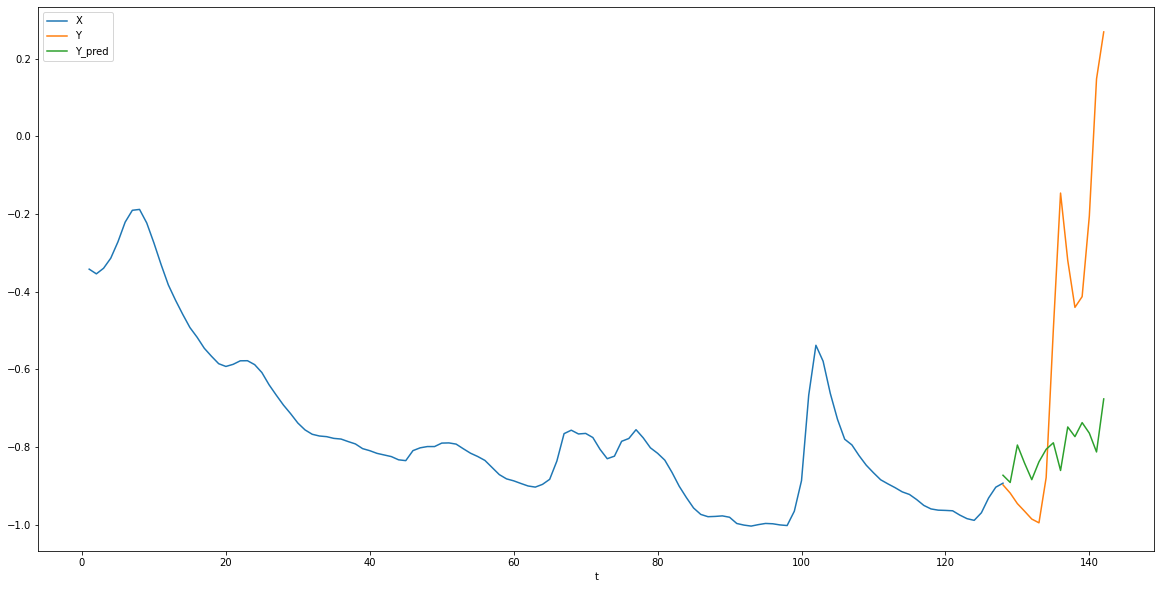

In [191]:
import matplotlib.pyplot as plt

Y_pred = get_predictions(trained_model, X_test)

idx = 678
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(X_test.iloc[idx].values[:128], Y_test.iloc[idx].values, Y_pred[idx])

# 2. MLP with DWT and times series

## 2.1. Generate training data

In [238]:
# Training data generation parameters

wavelet      = 'db8'
include_ts   = True
shift        = 1
split        = [.8, .1, .1]

In [239]:
%%time

X_train, X_valid, X_test, Y_train, Y_valid, Y_test, train_avg, train_std = generate_training_data(
    windows, input_width, target_width, wavelet, include_ts, shift, split
)

Spliting data into training, validation and testing datasets...
Spliting model inputs and outputs (X and Y)
Calculate average and standard deviation for training dataset...
Training dataset average: 16144.77
Training dataset standard deviation: 7689.77
Scaling training, validation and testing datasets using z-score...
Returning values with DWT transformation with db8 wavelet.
CPU times: user 2.38 s, sys: 23.6 ms, total: 2.4 s
Wall time: 2.41 s


## 2.2. Compile model

In [196]:
input_dim = len(X_train.columns) # Number of points in X samples
model = create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics)

## 2.3. Training the model

In [197]:
epochs = 20
tensorboard_log_dir = '/usr/src/code/data/tensorboard'
train_index = 'exp_mlp_dwt_ts_{}e_l1xl2_{}x{}_lr_{}'.format(epochs, layer_1, layer_2, lr)

In [199]:
%%time

trained_model, history = train_model(model,
    X_train, Y_train,
    X_valid, Y_valid,
    epochs,
    tensorboard_log_dir,
    train_index
)

Epoch 1/20
197/197 [==============================] - 4s 20ms/step - loss: 1.1588 - root_mean_squared_error: 1.0765 - mean_absolute_error: 0.8441 - mean_squared_error: 1.1588 - mean_absolute_percentage_error: 445.6504 - val_loss: 0.9897 - val_root_mean_squared_error: 0.9948 - val_mean_absolute_error: 0.7823 - val_mean_squared_error: 0.9897 - val_mean_absolute_percentage_error: 255.4718
Epoch 2/20
197/197 [==============================] - 4s 20ms/step - loss: 0.8581 - root_mean_squared_error: 0.9263 - mean_absolute_error: 0.7224 - mean_squared_error: 0.8581 - mean_absolute_percentage_error: 331.4161 - val_loss: 0.8194 - val_root_mean_squared_error: 0.9052 - val_mean_absolute_error: 0.7033 - val_mean_squared_error: 0.8194 - val_mean_absolute_percentage_error: 221.0003
Epoch 3/20
197/197 [==============================] - 3s 16ms/step - loss: 0.6690 - root_mean_squared_error: 0.8179 - mean_absolute_error: 0.6344 - mean_squared_error: 0.6690 - mean_absolute_percentage_error: 285.6607 - va

## 2.4. Evaluate the model

In [200]:
results_2 = evaluate(trained_model, X_test, Y_test)

25/25 [==============================] - 0s 4ms/step - loss: 0.2204 - root_mean_squared_error: 0.4694 - mean_absolute_error: 0.3319 - mean_squared_error: 0.2204 - mean_absolute_percentage_error: 964.3450


In [201]:
results_2

[0.22036051750183105,
 0.46942567825317383,
 0.33188214898109436,
 0.22036051750183105,
 964.344970703125]

## 2.5. Plot predicitions

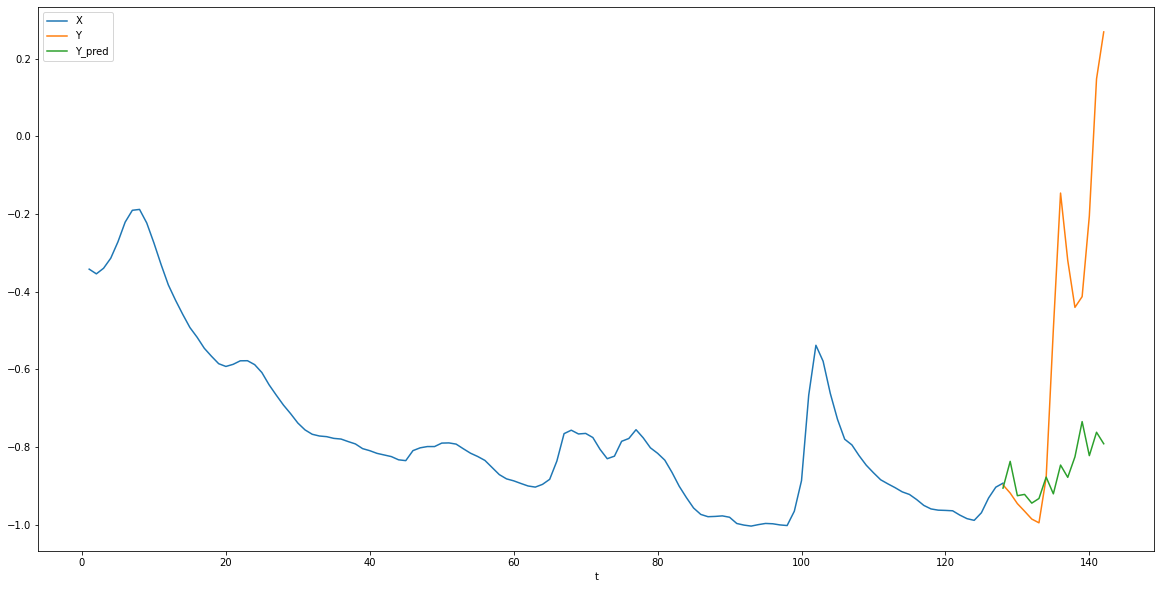

In [202]:
import matplotlib.pyplot as plt

Y_pred = get_predictions(trained_model, X_test)

idx = 678
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(X_test.iloc[idx].values[:128], Y_test.iloc[idx].values, Y_pred[idx])

# 3. MLP with DWT

## 3.1. Generate training data

In [271]:
# Training data generation parameters

wavelet      = 'db8'
include_ts   = False
shift        = 1
split        = [.8, .1, .1]

In [272]:
%%time

X_train, X_valid, X_test, Y_train, Y_valid, Y_test, train_avg, train_std = generate_training_data(
    windows, input_width, target_width, wavelet, include_ts, shift, split
)

Spliting data into training, validation and testing datasets...
Spliting model inputs and outputs (X and Y)
Calculate average and standard deviation for training dataset...
Training dataset average: 16144.77
Training dataset standard deviation: 7689.77
Scaling training, validation and testing datasets using z-score...
Returning values with DWT transformation with db8 wavelet.
CPU times: user 2.01 s, sys: 39.2 ms, total: 2.05 s
Wall time: 2.05 s


## 3.2. Compile model

In [273]:
input_dim = len(X_train.columns) # Number of points in X samples
model = create_model(input_dim, output_dim, layer_1, layer_2, lr, metrics)

## 3.3. Training the model

In [274]:
epochs = 20
tensorboard_log_dir = '/usr/src/code/data/tensorboard'
train_index = 'exp3_mlp_dwt_{}e_l1xl2_{}x{}_lr_{}'.format(epochs, layer_1, layer_2, lr)

In [275]:
%%time

trained_model, history = train_model(model,
    X_train, Y_train,
    X_valid, Y_valid,
    epochs,
    tensorboard_log_dir,
    train_index
)

Epoch 1/20
197/197 [==============================] - 3s 12ms/step - loss: 1.0376 - root_mean_squared_error: 1.0186 - mean_absolute_error: 0.8003 - mean_squared_error: 1.0376 - mean_absolute_percentage_error: 413.8390 - val_loss: 0.9476 - val_root_mean_squared_error: 0.9734 - val_mean_absolute_error: 0.7654 - val_mean_squared_error: 0.9476 - val_mean_absolute_percentage_error: 249.3443
Epoch 2/20
197/197 [==============================] - 2s 12ms/step - loss: 0.8156 - root_mean_squared_error: 0.9031 - mean_absolute_error: 0.7069 - mean_squared_error: 0.8156 - mean_absolute_percentage_error: 322.6018 - val_loss: 0.8088 - val_root_mean_squared_error: 0.8993 - val_mean_absolute_error: 0.6984 - val_mean_squared_error: 0.8088 - val_mean_absolute_percentage_error: 205.1589
Epoch 3/20
197/197 [==============================] - 3s 15ms/step - loss: 0.6680 - root_mean_squared_error: 0.8173 - mean_absolute_error: 0.6361 - mean_squared_error: 0.6680 - mean_absolute_percentage_error: 274.9283 - va

## 3.4. Evaluate the model

In [276]:
results_3 = evaluate(trained_model, X_test, Y_test)

25/25 [==============================] - 0s 3ms/step - loss: 0.2161 - root_mean_squared_error: 0.4648 - mean_absolute_error: 0.3271 - mean_squared_error: 0.2161 - mean_absolute_percentage_error: 809.0226


In [277]:
results_3

[0.2160804122686386,
 0.4648444950580597,
 0.32708919048309326,
 0.2160804122686386,
 809.0225830078125]

## 3.5. Plot predicitions

In [249]:
%%time

# Training data generation parameters

wavelet      = 'db8'
include_ts   = True
shift        = 1
split        = [.8, .1, .1]

z_X_train, z_X_valid, z_X_test, z_Y_train, z_Y_valid, z_Y_test, z_train_avg, z_train_std = generate_training_data(
    windows, input_width, target_width, wavelet, include_ts, shift, split
)

Spliting data into training, validation and testing datasets...
Spliting model inputs and outputs (X and Y)
Calculate average and standard deviation for training dataset...
Training dataset average: 16144.77
Training dataset standard deviation: 7689.77
Scaling training, validation and testing datasets using z-score...
Returning values with DWT transformation with db8 wavelet.
CPU times: user 2.18 s, sys: 19.5 ms, total: 2.2 s
Wall time: 2.22 s


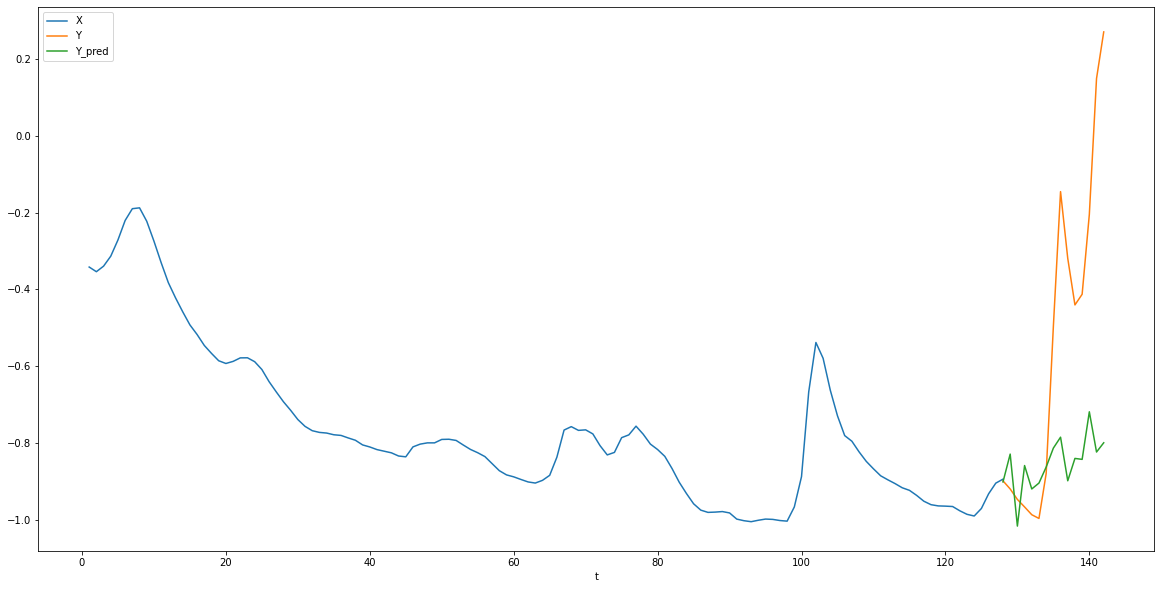

In [253]:
import matplotlib.pyplot as plt

Y_pred = get_predictions(trained_model, X_test)

idx = 678
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(z_X_test.iloc[idx].values[:128], Y_test.iloc[idx].values, Y_pred[idx])

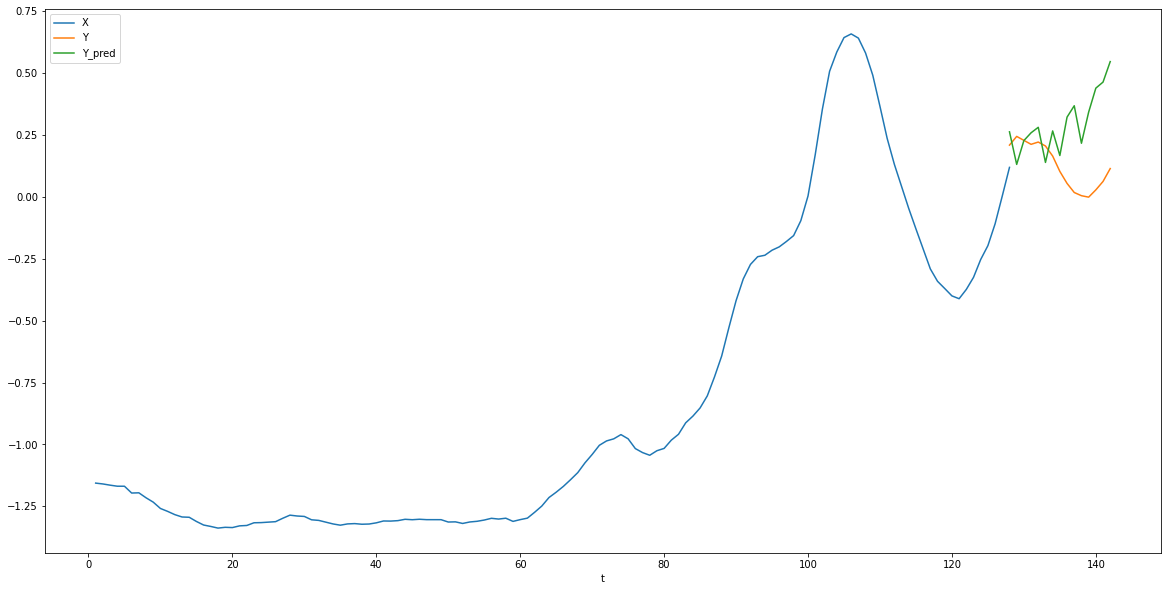

In [270]:
import matplotlib.pyplot as plt

Y_pred = get_predictions(trained_model, X_train)

idx = 678
plt.rcParams["figure.figsize"] = (20, 10)

df = plot_predictions(z_X_train.iloc[idx].values[:128], Y_train.iloc[idx].values, Y_pred[idx])

# Resultados

<img src="img/results.png">